# 07: Quartz cementation modelling

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['font.size']=14
plt.rcParams['font.family']='arial'

<div class="alert alert-block alert-success">
<b>Learning Objectives:</b>
<ul>
    <li>Modelling porosity loss due to mechanical compaction</li>
    <li>Modelling porosity loss due to quartz cementation </li>
</ul>
</div>

## Modelling porosity loss due to mechanical compaction
The Lander and Walderhaug (1999) equations, which gives the pore space within the mechanical compaction domain as the intergranular volume (IGV) of a clean uncemented sand as 

$
IGV=IGV_f+(\phi_0-IGV_f)e^{-\beta\sigma_{eff}}
$

In [2]:
def exp_decay(c, phic, Z):
    """compute porosity reduction caused by mechanical compaction using Arthy equation. Written by Jiaxin Yu (July 2021)

    Args:
        c (1/m): exponentional decay parameter
        phic (frac): depositional porosity
        Z (m): burial depth

    Returns:
        phi (frac): porosity
    """    
    phi= phic*np.exp(-c*Z)
    return phi

def IGV(IGV_f,phic,beta,sigma ):
    """model porosity evolution of a clean, uncemented sand caused by mechanical compaction using the Lander and Walderhaug (1999) equations. Written by Jiaxin Yu (July 2021)

    Args:
        IGV_f (frac): stable packing configuration, which is the smallest porosity possible by mechanical compaction alone.
        phic (frac): depositional porosity 
        beta (1/MPa): exponential rate of IGV decline with effective stress, the higher, the more severe mechanical compaction the rock experienced. 0.06 is taken in Torset （2020) and 0.12  is taken in Bredesen（2017).
        sigma (MPa):  maximum effective stress 
    Returns:
        IGV (frac): Intergranular volume: part of the rock between grains
    """    
    IGV=IGV_f+(phic-IGV_f)*np.exp(-beta*sigma)
    return IGV

## Quartz cementation modeling
Walderhaug (1996) proposed a model that gives the cement volume at a give time step as 

$
V_{cem(i)}=  \phi_c-(\phi_c-V_{cem(i-1)}) \exp(\frac{-MA_0a}{bc\rho _{ma}\phi_cln(10)} (10^{b(ct_i+d)}-10^{b(ct_{(i-1)}+d)}) )
$ 

when assuming a linear time-temperature history 
$
T=ct+d
$


In [3]:
def Qz_cement(n,tcem,phic,cc, d=70,D=0.03,f_q=0.85,a=1.981*10**-22,b=0.022,M=60.9,coat=0,den_q=2.65):
    """Quantify volume of quartz precipite in the pore space in a period of time using Walderhaug (1994a, 1996) kinetic equations. Written by Jiaxin Yu (July 2021)

    Args:
        n (int): additive time step, default 1 for 1 m.y timestep
        tcem (m.y.): Cementation time
        phic (frac):  porosity at the start of cementation
        cc: (°C/m.y.):  heating rate. 
        d (°C): Temperature at the onset of cementation. Defaults to 70.
        D (mm): grain diameter. Defaults to 0.03.
        f_q (frac): volume fraction of intergranular quartz in a unit volume V . Defaults to 0.85.
        a (moles/cm2 s): kinetic constants. Defaults to 1.981*10**-22.
        b (°C−1): kinetic constants. Defaults to 0.022.
        M ( g/mole): molar mass of quartz. Defaults to 60.9.
        coat (int, optional):. Grain coatings prohibiting further quartz overgrowth are compensated 
        by the factor. Defaults to 0.
        den_q (g/cm3):  density of quartz. Defaults to 2.65.
    Returns:
        V (frac): volume fraction of quartz cementation
        Por (frac): remaining porosity after cementation
        A (cm2/cm3): surface area remained
    """    
    convert=365*24*60*60*1000000
    a=a*convert # moles/ (cm2 my.)
    A0=6*(1-coat)*f_q/D # V is 1 cm3 initial quartz grains surface area
    tt=np.linspace(0,tcem,(int(tcem)+1)*n) # time step, usually set to 1 my 
    V=np.zeros(len(tt))
    A=np.zeros(len(tt))
    Por=np.zeros(len(tt))
    A[0]=A0
    Por[0]=phic
    for i in range(1,len(tt)):
    
        Term1=-M*a*A0/(den_q*phic*b*cc*np.log(10))
        Term2=10**(b*(cc*tt[i]+d))-10**(b*(cc*tt[i-1]+d)) 
        V[i]=phic-(phic-V[i-1])*np.exp(Term1*Term2)

        A[i]=A[0]*(1-V[i]/phic)
        Por[i]=phic-V[i]
    return V, Por, A,tt

## Examples
* Let's model the porosity loss due to quartz cementation using Walderhaug model.

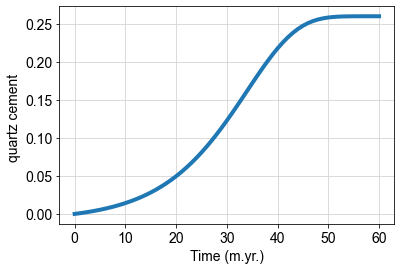

In [4]:
# specify model parameters
n=1
tcem=60
phic=0.26
cc=2
V, Por, A,tt= Qz_cement(n,tcem,phic,cc)
# plot
plt.plot(tt,V,lw=4)
plt.xlabel('Time (m.yr.)')
plt.ylabel('quartz cement ')
plt.grid(color='lightgrey')


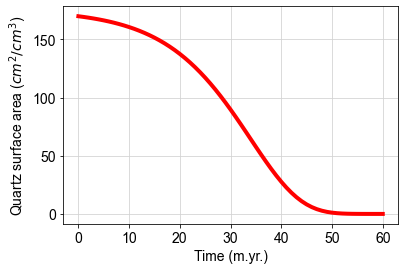

In [5]:
plt.plot(tt,A,lw=4,c='red')
plt.xlabel('Time (m.yr.)')
plt.ylabel('Quartz surface area ($cm^2/cm^3$)')
plt.grid(color='lightgrey')


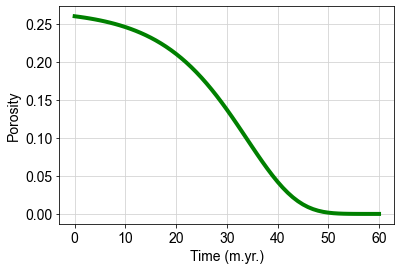

In [6]:
plt.plot(tt,Por,lw=4,c='green')

plt.xlabel('Time (m.yr.)')
plt.ylabel('Porosity')
plt.grid(color='lightgrey')


<div class="alert alert-block alert-info">
<b>Reference:</b> 
<ul>
    <li>Mavko, G., Mukerji, T. and Dvorkin, J., 2020. The rock physics handbook. Cambridge university press.
</li>
    <li>Bredesen, K., Avseth, P., Johansen, T.A. and Olstad, R., 2019. Rock physics modelling based on depositional and burial history of Barents Sea sandstones. Geophysical Prospecting, 67(4-Rock Physics: from microstructure to seismic signatures), pp.825-842.
</li>
</ul>
</div>